# LBM Step 3: Segmentation

## Segmentation: Extract neuronal locations and planar time-traces.

- Apply the constrained nonnegative matrix factorization (CNMF) source separation algorithm to extract initial estimates of neuronal spatial footprints and calcium traces.
- Apply quality control metrics to evaluate the initial estimates, and narrow down to the final set of estimates.

# Caiman docs on component eval

https://caiman.readthedocs.io/en/latest/Getting_Started.html#component-evaluation

> The quality of detected components is evaluated with three parameters:
>
> Spatial footprint consistency (rval): The spatial footprint of the component is compared with the frames where this component is active. Other component’s signals are subtracted from these frames, and the resulting raw data is correlated against the spatial component. This ensures that the raw data at the spatial footprint aligns with the extracted trace.
>
> Trace signal-noise-ratio (SNR): Peak SNR is calculated from strong calcium transients and the noise estimate.
>
> CNN-based classifier (cnn): The shape of components is evaluated by a 4-layered convolutional neural network trained on a manually annotated dataset. The CNN assigns a value of 0-1 to each component depending on its resemblance to a neuronal soma.
> 
> Each parameter has a low threshold:
> - (rval_lowest (default -1), SNR_lowest (default 0.5), cnn_lowest (default 0.1))
>
> and high threshold
> 
> - (rval_thr (default 0.8), min_SNR (default 2.5), min_cnn_thr (default 0.9))
> 
> A component has to exceed ALL low thresholds as well as ONE high threshold to be accepted.

In [2]:
import sys
from pathlib import Path
import os
import numpy as np
import zarr

import logging
import mesmerize_core as mc
import matplotlib.pyplot as plt

try:
    import cv2
    cv2.setNumThreads(0)
except():
    pass

logging.basicConfig()

from mesmerize_core.caiman_extensions.cnmf import cnmf_cache
import fastplotlib as fpl

os.environ["CONDA_PREFIX_1"] = ""
if os.name == "nt":
    # disable the cache on windows, this will be automatic in a future version
    cnmf_cache.set_maxsize(0)

raw_data_path = Path().home() / "caiman_data"
movie_path = raw_data_path / 'animal_01' / "session_01" / 'save_gui.zarr'


2024-09-06 14:25:42.008491: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 14:25:42.008521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 14:25:42.008939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
jupyter: No module named 'jupyter_rfb'
qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in ""


# Paths (TODO)

```
/ raw_data_path/
    └── session_01
        ├── animal_01
        │   ├── pre_processed/
        │   │   ├── plane_1/
        │   │   ├── plane_1/
        │   │   ├── plane_2/
        │   │   └── plane_N/
        │   └── batch_dataframe.pickle
```

**For this demo set the `caiman_data` dir as the parent raw data path**

### Batch path, this is where caiman outputs will be organized, same as the previous step

This can be anywhere, it does not need to be under the parent raw data path.

In [3]:
batch_path = raw_data_path / 'batch.pickle'
mc.set_parent_raw_data_path(str(raw_data_path))

# you could alos load the registration batch and 
# save this patch in a new dataframe (saved to disk automatically)
try:
    df = mc.load_batch(batch_path)
except (IsADirectoryError, FileNotFoundError):
    df = mc.create_batch(batch_path)

df=df.caiman.reload_from_disk()
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,save_gui,animal_01/session_01/save_gui.zarr,"{'main': {'var_name_hdf5': 'plane_2', 'max_shi...",{'mean-projection-path': 9781250d-22cb-4ebc-9d...,2024-09-06T00:19:51,2024-09-06T00:33:05,764.98 sec,None,9781250d-22cb-4ebc-9de1-ad97e101ddee
1,mcorr,save_gui,animal_01/session_01/save_gui.zarr,"{'main': {'var_name_hdf5': 'plane_2', 'max_shi...",{'mean-projection-path': 5ffcad60-5506-4243-93...,2024-09-06T00:19:51,2024-09-06T00:35:31,142.87 sec,None,5ffcad60-5506-4243-936c-f8473ff4ab50
2,mcorr,save_gui,animal_01/session_01/save_gui.zarr,"{'main': {'var_name_hdf5': 'plane_2', 'max_shi...",{'mean-projection-path': 0a463c4f-985d-47a4-9e...,2024-09-06T00:19:51,2024-09-06T00:48:21,766.17 sec,None,0a463c4f-985d-47a4-9e95-cf776d98a1a3
3,mcorr,save_gui,animal_01/session_01/save_gui.zarr,"{'main': {'var_name_hdf5': 'plane_2', 'max_shi...",{'mean-projection-path': 8cb260f3-ced8-4433-b9...,2024-09-06T00:19:51,2024-09-06T00:50:47,142.94 sec,None,8cb260f3-ced8-4433-b9bf-fd6116b20964
4,cnmf,save_gui,8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...",{'mean-projection-path': 3db5aac3-b8ab-449c-9b...,2024-09-06T02:52:12,2024-09-06T02:54:12,100.68 sec,None,3db5aac3-b8ab-449c-9b13-be7e6eaa19a7
5,cnmf,save_gui,8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...",{'mean-projection-path': 796af0f5-678c-4a73-99...,2024-09-06T02:55:26,2024-09-06T02:57:21,100.82 sec,None,796af0f5-678c-4a73-9991-d8d462e9d66a
6,cnmf,save_gui,8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...",{'mean-projection-path': e58bb527-8bd1-4652-82...,2024-09-06T02:55:26,2024-09-06T02:59:07,102.67 sec,None,e58bb527-8bd1-4652-82dd-bca82327a018
7,cnmf,save_gui,8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...",{'mean-projection-path': 4ae126bc-4bb1-4277-94...,2024-09-06T02:55:26,2024-09-06T03:01:48,158.05 sec,None,4ae126bc-4bb1-4277-946d-dbe472fde572
8,cnmf,save_gui,8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...",{'mean-projection-path': cf20ff30-e1cb-45ff-91...,2024-09-06T02:55:26,2024-09-06T03:04:37,166.19 sec,None,cf20ff30-e1cb-45ff-912a-c99b4a5939a3
9,cnmf,save_gui,8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...",{'mean-projection-path': 72001e65-2c76-4271-bb...,2024-09-06T02:55:26,2024-09-06T03:06:32,111.71 sec,None,72001e65-2c76-4271-bbd6-72b95ec8673e


In [6]:
df.iloc[-1].cnmf.get_output()


# CNMF

Perform CNMF using the mcorr output.

Similar to mcorr, put the CNMF params within the `main` key. The `refit` key will perform a second iteration, as shown in the `caiman` `demo_pipeline.ipynb` notebook.

In [3]:
# some params for CNMF
params_cnmf = {
    'main': # indicates that these are the "main" params for the CNMF algo
        {
            'fr': 30, # framerate, very important!
            'p': 1,
            'nb': 2,
            'merge_thr': 0.85,
            'rf': 15,
            'stride': 6, # "stride" for cnmf, "strides" for mcorr
            'K': 4,
            'gSig': [4, 4],
            'ssub': 1,
            'tsub': 1,
            'method_init': 'greedy_roi',
            'min_SNR': 2.0,
            'rval_thr': 0.7,
            'use_cnn': False,
            'decay_time': 0.4,
        },
    'refit': True, # If `True`, run a second iteration of CNMF
}

# Run CNMF

The API is identical to running mcorr.

You can provide the mcorr item row to `input_movie_path` and it will resolve the path of the input movie from the entry in the DataFrame.

In [4]:
run_last_item_flag = False
if run_last_item_flag:
    good_mcorr_index = 3

    # add a batch item
    df.caiman.add_item(
        algo='cnmf', # algo is cnmf
        input_movie_path=df.iloc[good_mcorr_index],  # use mcorr output from a completed batch item
        params=params_cnmf,
        item_name=df.iloc[good_mcorr_index]["item_name"], # use the same item name
    )

    index = -1  # most recently added item
    df.iloc[index].caiman.run()

# Reload dataframe

In [5]:
df = df.caiman.reload_from_disk()
df

NameError: name 'df' is not defined

# CNMF outputs

Similar to mcorr, you can use the `mesmerize-core` API to fetch the outputs. The API reference for CNMF is here: https://mesmerize-core.readthedocs.io/en/latest/api/cnmf.html

In [9]:
index = -1  # index of the cnmf item, last item in the dataframe

# temporal components
temporal = df.iloc[index].cnmf.get_temporal()

In [10]:
temporal.shape

(4629, 1730)

Many of the cnmf functions take a rich set of arguments

In [11]:
# get accepted or rejected components
temporal_good = df.iloc[index].cnmf.get_temporal("good")

# shape is [n_components, n_frames]
temporal_good.shape

(273, 1730)

### Get specific components

In [8]:
df.iloc[-1].cnmf.get_temporal(np.array([1, 5, 9]))

array([[-1164.26197784,   482.41381104,   524.05762701, ...,
          146.58582648,  -103.30837119,  -305.56385525],
       [ -976.41859592,  1333.52341395,   895.44232658, ...,
           40.63645868,  -152.24833724,  -308.55249443],
       [ -291.12191069,   811.46900584,   886.63938853, ...,
         -177.02657974,  -193.8651116 ,  -208.21858463]])

### add risiduals / contours

In [29]:
# get temporal with the residuals, i.e. C + YrA
temporal_with_residuals = df.iloc[index].cnmf.get_temporal(add_residuals=True)

In [30]:
# get contours
contours = df.iloc[index].cnmf.get_contours()

Returns: `(list of np.ndarray of contour coordinates, list of center of mass)`

In [31]:
print(f"contour 0 coordinates:\n\n{contours[0][0]}\n\n com: {contours[1][0]}")

contour 0 coordinates:

[[20.         25.01558346]
 [19.         25.60646128]
 [18.         25.2845259 ]
 [17.5524056  25.        ]
 [17.         24.57330747]
 [16.         24.46959915]
 [15.59287146 25.        ]
 [15.         25.62280392]
 [14.         25.49757361]
 [13.         25.22684176]
 [12.6570361  25.        ]
 [12.         24.48841853]
 [11.45336193 24.        ]
 [11.         23.66266051]
 [10.         23.51538548]
 [ 9.19089959 23.        ]
 [ 9.         22.78334966]
 [ 8.73803854 22.        ]
 [ 8.11875789 21.        ]
 [ 8.         20.59387852]
 [ 7.6882345  20.        ]
 [ 7.16678103 19.        ]
 [ 7.1318453  18.        ]
 [ 7.08960039 17.        ]
 [ 7.         16.5785856 ]
 [ 6.65247425 16.        ]
 [ 6.50517672 15.        ]
 [ 6.40926157 14.        ]
 [ 6.28386307 13.        ]
 [ 6.55689294 12.        ]
 [ 7.         11.52766769]
 [ 7.5171354  11.        ]
 [ 8.         10.51930536]
 [ 8.54780523 11.        ]
 [ 9.         11.36939161]
 [10.         11.35715476]
 [11

In [1]:
len(contours)

NameError: name 'contours' is not defined

In [33]:
# get_contours() also takes arguments
contours_good = df.iloc[index].cnmf.get_contours("good")

In [34]:
len(contours_good[0]) # number of contours

161

swap_dim

In [12]:
# get the first contour using swap_dim=True (default)
swap_dim_true = df.iloc[index].cnmf.get_contours()[0][0]

In [13]:
# get the first contour  with swap_dim=False
swap_dim_false = df.iloc[index].cnmf.get_contours(swap_dim=False)[0][0]

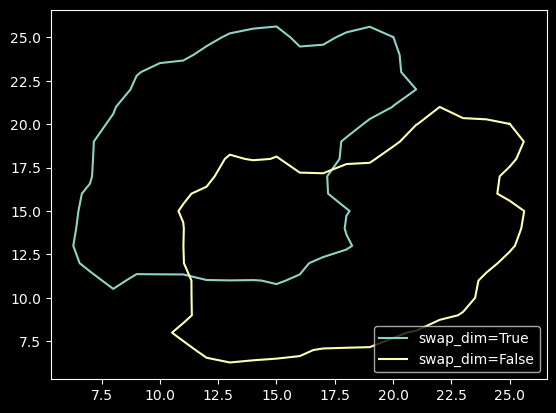

In [37]:
plt.plot(
    swap_dim_true[:, 0], 
    swap_dim_true[:, 1], 
    label="swap_dim=True"
)
plt.plot(
    swap_dim_false[:, 0], 
    swap_dim_false[:, 1], 
    label="swap_dim=False"
)
plt.legend()

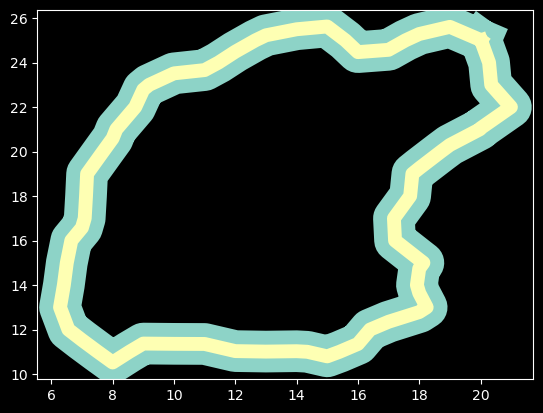

In [38]:
# swap_dim swaps the x and y dims
plt.plot(
    swap_dim_true[:, 0], 
    swap_dim_true[:, 1], 
    linewidth=30
)
plt.plot(
    swap_dim_false[:, 1], 
    swap_dim_false[:, 0], 
    linewidth=10
)

# Reconstructed movie - `A * C`
# Reconstructed background - `b * f`
# Residuals - `Y - AC - bf` 

Mesmerize-core provides these outputs as lazy arrays. This allows you to work with arrays that would otherwise be hundreds of gigabytes or terabytes in size.

In [14]:
rcm = df.iloc[index].cnmf.get_rcm()
rcm

LazyArrayRCM @0x7f5373a07910
LazyArray for reconstructed movie, i.e. A ⊗ C
Frames are computed only upon indexing
shape [frames, x, y]: (1730, 600, 560)
n_components: 4629

LazyArrays behave like numpy arrays

In [15]:
rcm[42]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -3.802735  ,  6.63209673, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  6.89688434,  8.99901868, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        , -0.30221454, -0.41923418, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.3223725 , -0.41923418, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [16]:
rcm[10:20].shape

(10, 600, 560)

# Using LazyArrays

In [42]:
rcm_accepted = df.iloc[index].cnmf.get_rcm("good")
rcm_rejected = df.iloc[index].cnmf.get_rcm("bad")

# All CNMF LazyArrays

In [17]:
rcb = df.iloc[index].cnmf.get_rcb()
residuals = df.iloc[index].cnmf.get_residuals()
input_movie = df.iloc[index].caiman.get_input_movie()

In [22]:
rcb.shape

(1730, 600, 560)

In [23]:
import napari
napari.view_image(rcb)

Viewer(camera=Camera(center=(0.0, 299.5, 279.5), zoom=1.3079464285714284, angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True), cursor=Cursor(position=(864.0, 1.0, 0.0), scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=0.0, stop=1729.0, step=1.0), RangeTuple(start=0.0, stop=599.0, step=1.0), RangeTuple(start=0.0, stop=559.0, step=1.0)), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(864.0, 299.0, 279.0), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'rcb' at 0x7f53578a7f50>], help='use <2> for transform', status='Ready', tooltip=Tooltip(visible=False, text=''), theme='dark', title='napari', mouse_over_canvas=False, mouse_move_callbacks=[], mouse_drag_callbacks=[], mouse_double_click_callbacks=[], mouse_wheel_callbacks=[<function dims_scroll at 0x7f53560702

: 

# Parameter Gridsearch

As shown for motion correction, the purpose of `mesmerize-core` is to perform parameter searches

In [46]:
# itertools.product makes it easy to loop through parameter variants
# basically, it's easier to read that deeply nested for loops
from copy import deepcopy
from itertools import product

# variants of several parameters
gSig_variants = [4, 6]
K_variants = [4, 8]
merge_thr_variants = [0.8, 0.95]

# always use deepcopy like before
new_params_cnmf = deepcopy(params_cnmf)

# create a parameter grid
parameter_grid = product(gSig_variants, K_variants, merge_thr_variants)

# a single for loop to go through all the various parameter combinations
for gSig, K, merge_thr in parameter_grid:
    # deep copy params dict just like before
    new_params_cnmf = deepcopy(new_params_cnmf)
    
    new_params_cnmf["main"]["gSig"] = [gSig, gSig]
    new_params_cnmf["main"]["K"] = K
    new_params_cnmf["main"]["merge_thr"] = merge_thr
    
    # add param combination variant to batch
    df.caiman.add_item(
        algo="cnmf",
        item_name=df.iloc[good_mcorr_index]["item_name"],  # good mcorr item
        input_movie_path=df.iloc[good_mcorr_index],
        params=new_params_cnmf
    )

We now have lot of cnmf items

In [47]:
df

,algo,item_name,input_movie_path,params,outputs,added_time,ran_time,algo_duration,comments,uuid
0,mcorr,save_gui,animal_01/session_01/save_gui.zarr,"{'main': {'var_name_hdf5': 'plane_2', 'max_shi...",{'mean-projection-path': 9781250d-22cb-4ebc-9d...,2024-09-06T00:19:51,2024-09-06T00:33:05,764.98 sec,None,9781250d-22cb-4ebc-9de1-ad97e101ddee
1,mcorr,save_gui,animal_01/session_01/save_gui.zarr,"{'main': {'var_name_hdf5': 'plane_2', 'max_shi...",{'mean-projection-path': 5ffcad60-5506-4243-93...,2024-09-06T00:19:51,2024-09-06T00:35:31,142.87 sec,None,5ffcad60-5506-4243-936c-f8473ff4ab50
2,mcorr,save_gui,animal_01/session_01/save_gui.zarr,"{'main': {'var_name_hdf5': 'plane_2', 'max_shi...",{'mean-projection-path': 0a463c4f-985d-47a4-9e...,2024-09-06T00:19:51,2024-09-06T00:48:21,766.17 sec,None,0a463c4f-985d-47a4-9e95-cf776d98a1a3
3,mcorr,save_gui,animal_01/session_01/save_gui.zarr,"{'main': {'var_name_hdf5': 'plane_2', 'max_shi...",{'mean-projection-path': 8cb260f3-ced8-4433-b9...,2024-09-06T00:19:51,2024-09-06T00:50:47,142.94 sec,None,8cb260f3-ced8-4433-b9bf-fd6116b20964
4,cnmf,save_gui,8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...",{'mean-projection-path': 3db5aac3-b8ab-449c-9b...,2024-09-06T02:52:12,2024-09-06T02:54:12,100.68 sec,None,3db5aac3-b8ab-449c-9b13-be7e6eaa19a7
5,cnmf,save_gui,8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...",None,2024-09-06T02:55:26,None,None,None,796af0f5-678c-4a73-9991-d8d462e9d66a
6,cnmf,save_gui,8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...",None,2024-09-06T02:55:26,None,None,None,e58bb527-8bd1-4652-82dd-bca82327a018
7,cnmf,save_gui,8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...",None,2024-09-06T02:55:26,None,None,None,4ae126bc-4bb1-4277-946d-dbe472fde572
8,cnmf,save_gui,8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...",None,2024-09-06T02:55:26,None,None,None,cf20ff30-e1cb-45ff-912a-c99b4a5939a3
9,cnmf,save_gui,8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...",None,2024-09-06T02:55:26,None,None,None,72001e65-2c76-4271-bbd6-72b95ec8673e


View the diffs

In [9]:
df.caiman.get_params_diffs(algo="cnmf", item_name=df.iloc[-1]["item_name"])

,merge_thr,K,gSig
4,0.85,4,"(4, 4)"
5,0.8,4,"(4, 4)"
6,0.95,4,"(4, 4)"
7,0.8,8,"(4, 4)"
8,0.95,8,"(4, 4)"
9,0.8,4,"(6, 6)"
10,0.95,4,"(6, 6)"
11,0.8,8,"(6, 6)"
12,0.95,8,"(6, 6)"


# Run the `cnmf` batch items

In [49]:
for i, row in df.iterrows():
    if row["outputs"] is not None: # item has already been run
        continue # skip
        
    process = row.caiman.run()
    
    # on Windows you MUST reload the batch dataframe after every iteration because it uses the `local` backend.
    # this is unnecessary on Linux & Mac
    # "DummyProcess" is used for local backend so this is automatic
    if process.__class__.__name__ == "DummyProcess":
        df = df.caiman.reload_from_disk()

2024-09-06 02:55:39.193366: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 02:55:39.193397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 02:55:39.193775: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                    save_gui
input_movie_path    8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
added_time                                        2024-09-06T02:55:26
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             796af0f5-678c-4a73-9991-d8d462e9d66a
Name: 5, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (4, 4), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'r

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


making memmap


performing CNMF
fitting images
refitting
performing eval


2024-09-06 02:57:23.219120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 02:57:23.219154: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 02:57:23.219536: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                    save_gui
input_movie_path    8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
added_time                                        2024-09-06T02:55:26
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             e58bb527-8bd1-4652-82dd-bca82327a018
Name: 6, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (4, 4), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, '

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


making memmap


performing CNMF
fitting images
refitting
performing eval


2024-09-06 02:59:09.123700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 02:59:09.123733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 02:59:09.124122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                    save_gui
input_movie_path    8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
added_time                                        2024-09-06T02:55:26
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             4ae126bc-4bb1-4277-946d-dbe472fde572
Name: 7, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (4, 4), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'r

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


making memmap


performing CNMF
fitting images
refitting
performing eval


2024-09-06 03:01:50.415064: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 03:01:50.415100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 03:01:50.415485: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                    save_gui
input_movie_path    8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
added_time                                        2024-09-06T02:55:26
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             cf20ff30-e1cb-45ff-912a-c99b4a5939a3
Name: 8, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (4, 4), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, '

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


making memmap


performing CNMF
fitting images
refitting
performing eval


2024-09-06 03:04:39.929497: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 03:04:39.929529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 03:04:39.929936: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                    save_gui
input_movie_path    8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
added_time                                        2024-09-06T02:55:26
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             72001e65-2c76-4271-bbd6-72b95ec8673e
Name: 9, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (6, 6), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'r

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


making memmap


performing CNMF
fitting images
refitting
performing eval


2024-09-06 03:06:34.969998: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 03:06:34.970033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 03:06:34.970431: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                    save_gui
input_movie_path    8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
added_time                                        2024-09-06T02:55:26
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             c960003a-aacf-47f7-853f-995538f72a4d
Name: 10, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (6, 6), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


making memmap


performing CNMF
fitting images
refitting
performing eval


2024-09-06 03:08:30.864889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 03:08:30.864924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 03:08:30.865327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                    save_gui
input_movie_path    8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
added_time                                        2024-09-06T02:55:26
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             0faa6a15-f3ee-4c34-b8cd-ce183161006a
Name: 11, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (6, 6), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, '

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


making memmap


performing CNMF
fitting images
refitting
performing eval


2024-09-06 03:11:37.623624: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 03:11:37.623657: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 03:11:37.624016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


************************************************************************

Starting CNMF item:
algo                                                             cnmf
item_name                                                    save_gui
input_movie_path    8cb260f3-ced8-4433-b9bf-fd6116b20964/8cb260f3-...
params              {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_th...
outputs                                                          None
added_time                                        2024-09-06T02:55:26
ran_time                                                         None
algo_duration                                                    None
comments                                                         None
uuid                             7d6c0c06-3222-4b26-be5c-578b66e2e532
Name: 12, dtype: object
With params:{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (6, 6), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 

The local backend is an alias for the multiprocessing backend, and the alias may be removed in some future version of Caiman


making memmap


performing CNMF
fitting images
refitting
performing eval


# Load outputs

In [1]:
df = df.caiman.reload_from_disk()
df

NameError: name 'df' is not defined